## Лабораторная №2


### 1. Описание задачи


Программа должна принимать на видео, первым кадром которого является крупное
изображение объекта, положение которого необходимо отследить. На каждом кадре видео, где данный объект виден, вокруг него должна рисоваться рамка с подписью. В примере объект прямоугольный и плоский, рамка должна максимально соответствовать реальному положению и границам объекта. Для простых алгоритмов поиска ключевых точек лучше выбирать объекты с большим
количеством текстур.

### 2. Реализация

#### 2.1. Загрузка зависимостей

In [ ]:
!pip install opencv-python-headless

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, clear_output


#### 2.2 Загрузка видео

In [ ]:
from google.colab import files

uploaded = files.upload()
video_path = list(uploaded.keys())[0]
print("Видео:", video_path)

Saving mona-lisa-blur-extra-credit.avi to mona-lisa-blur-extra-credit.avi
Видео: mona-lisa-blur-extra-credit.avi


#### 2.3 Параметры

In [ ]:
OUTPUT_PATH = "tracking_result.avi"
SHOW_EVERY = 30

# Canny
CANNY_LOW = 10
CANNY_HIGH = 100

# FAST
FAST_THRESHOLD = 10
MAX_POINTS = 80
MIN_POINTS = 10

# Lucas–Kanade
WIN_SIZE = 20
MAX_LEVEL = 0;
lk_params = dict(
    winSize=(WIN_SIZE, WIN_SIZE),
    maxLevel=MAX_LEVEL,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.03)
)


In [ ]:
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("Не удалось открыть видео")

fps = int(cap.get(cv2.CAP_PROP_FPS))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

ret, first_frame = cap.read()
if not ret:
    raise ValueError("Не удалось прочитать первый кадр")

old_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)


Задай ROI вручную (x, y, w, h)


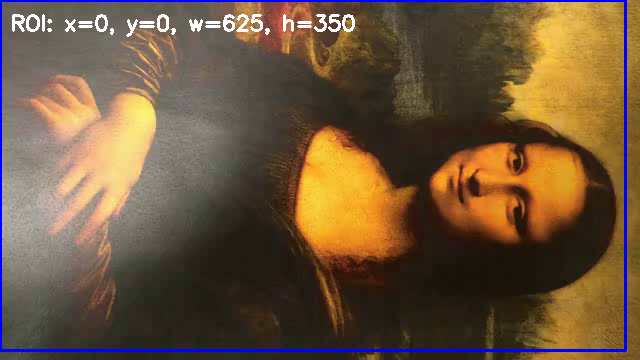

In [ ]:
print("Задай ROI вручную (x, y, w, h)")


# ROI: x, y, width, height
ROI = (0, 0, 625, 350)
x, y, w, h = ROI

preview = first_frame.copy()
cv2.rectangle(preview, (x, y), (x + w, y + h), (255, 0, 0), 2)  # синяя рамка
cv2.putText(
    preview,
    f"ROI: x={x}, y={y}, w={w}, h={h}",
    (10, 30),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7,
    (255, 255, 255),
    2
)

cv2_imshow(preview)

In [ ]:
# Границы
edges = np.zeros_like(old_gray)
edges_roi = cv2.Canny(old_gray[y:y+h, x:x+w], CANNY_LOW, CANNY_HIGH)
edges[y:y+h, x:x+w] = edges_roi


# FAST detector
fast = cv2.FastFeatureDetector_create(
    threshold=FAST_THRESHOLD,
    nonmaxSuppression=True
)

# Детектируем точки
keypoints = fast.detect(old_gray, mask=edges)

# В массив координат
p0 = np.array([kp.pt for kp in keypoints], dtype=np.float32).reshape(-1, 1, 2)

# Для визуализации
color = np.random.randint(0, 255, (len(p0), 3))
mask = np.zeros_like(first_frame)

print(f"Найдено ключевых точек: {len(p0)}")


Найдено ключевых точек: 200


Кадр 30


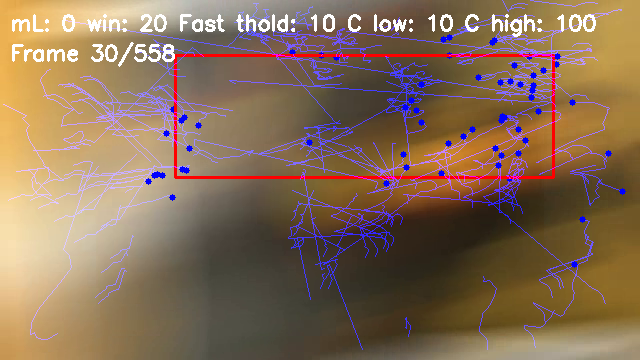

Кадр 60


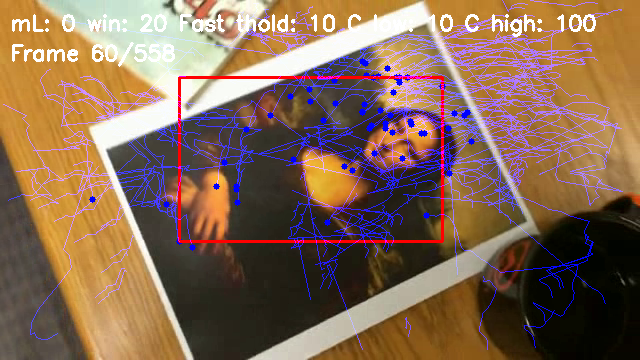

Кадр 90


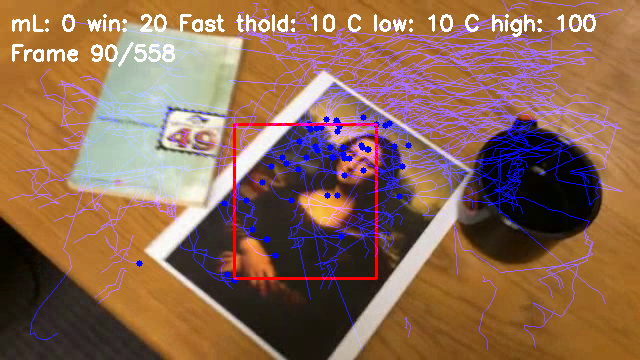

Кадр 120


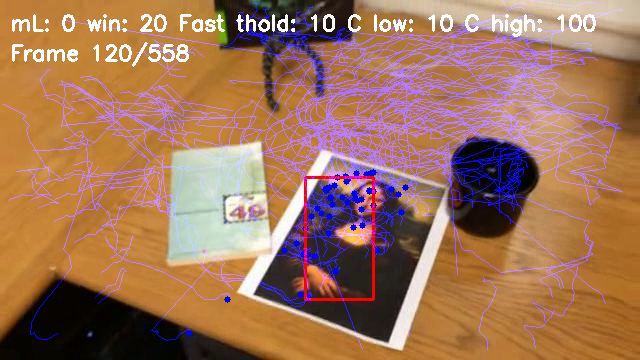

Кадр 150


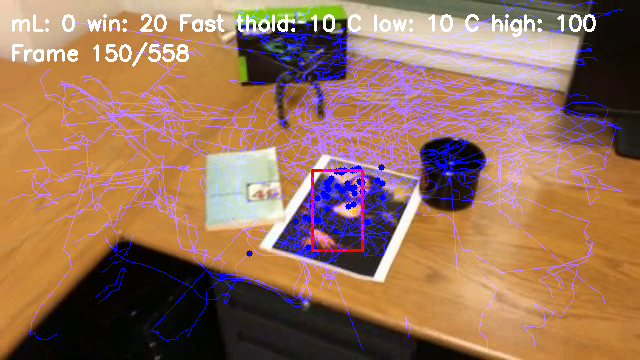

Кадр 180


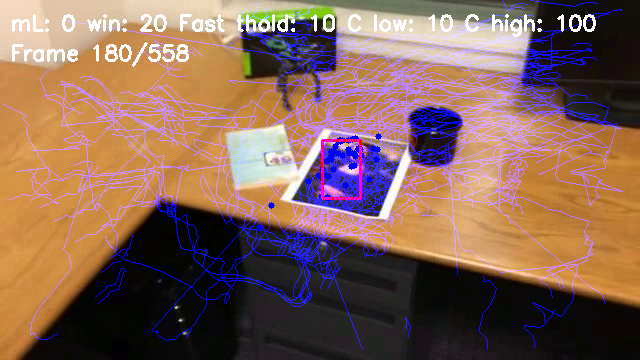

Кадр 210


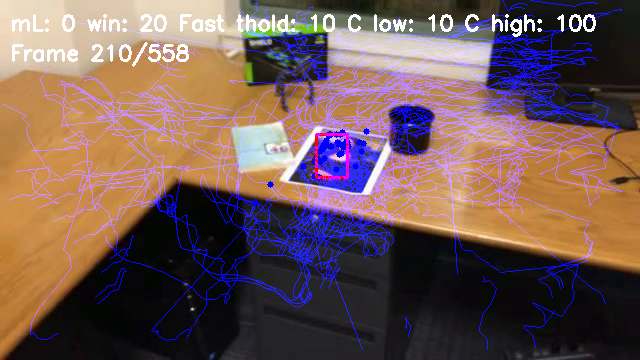

Кадр 240


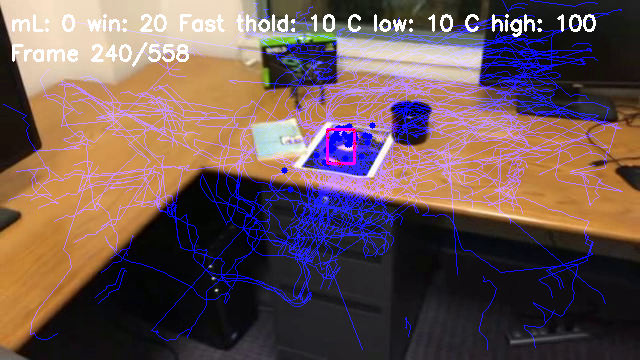

Кадр 270


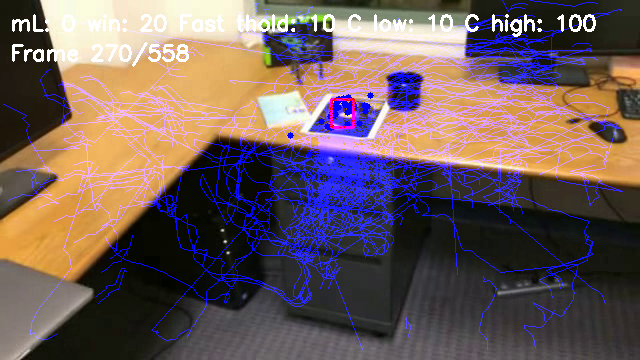

Кадр 300


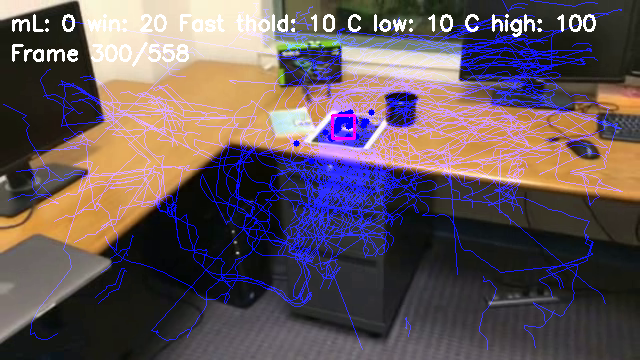

Кадр 330


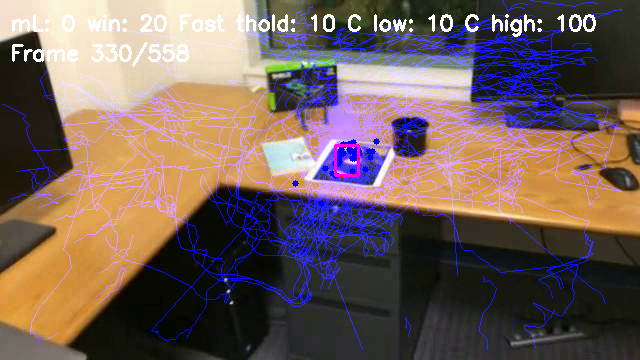

Кадр 360


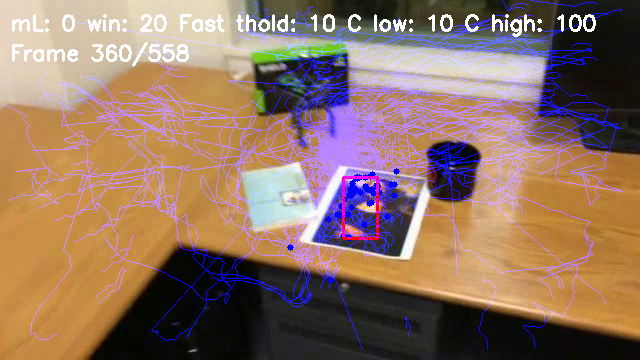

Кадр 390


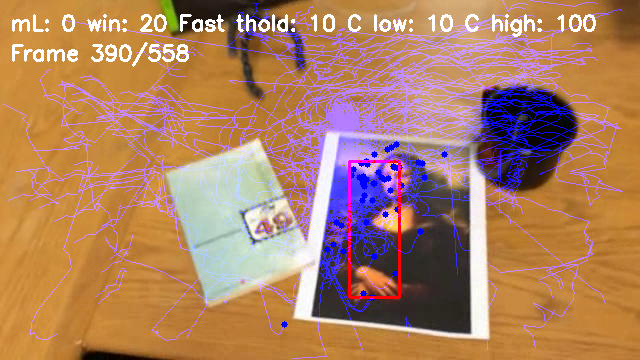

Кадр 420


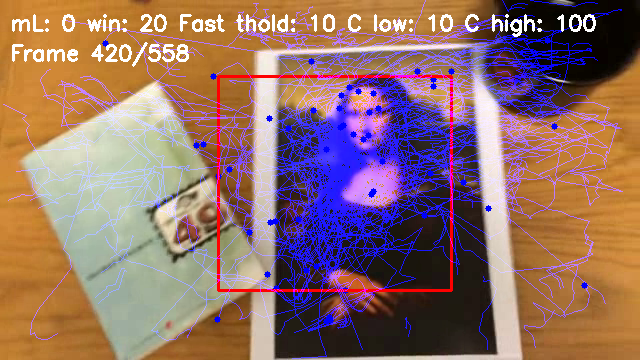

Кадр 450


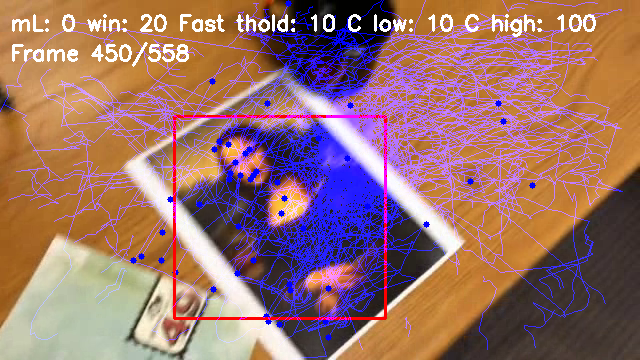

Кадр 480


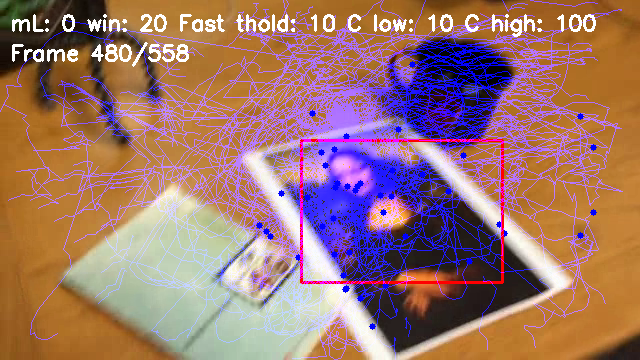

Кадр 510


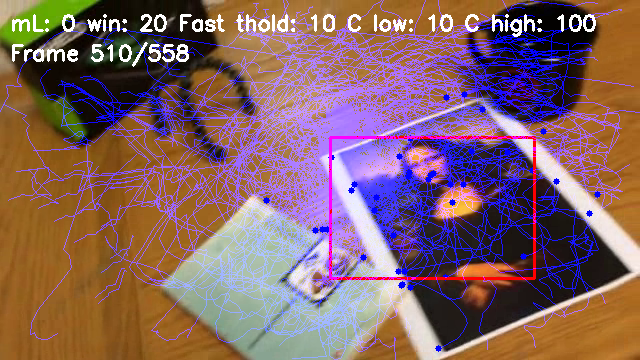

Кадр 540


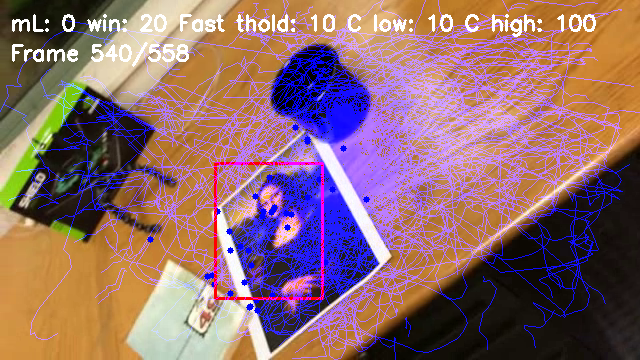

EOF


In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(
    OUTPUT_PATH,
    fourcc,
    fps,
    (width, height)
)

frame_idx = 1
TRAJ_COLOR = (255, 0, 0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("EOF")
        break

    frame_idx += 1
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Оптический поток
    p1, st, err = cv2.calcOpticalFlowPyrLK(
        old_gray, frame_gray, p0, None, **lk_params
    )

    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        good_colors = color[st.ravel() == 1]

        if len(good_new) >= MIN_POINTS:
            # Траектории
            for (new, old, col) in zip(good_new, good_old, good_colors):
                a, b = new.ravel().astype(int)
                c, d = old.ravel().astype(int)
                mask = cv2.line(mask, (a, b), (c, d), TRAJ_COLOR, 1)
                frame = cv2.circle(frame, (a, b), 3, TRAJ_COLOR, -1)


            # Bounding box (робастно)
            xs = good_new[:, 0]
            ys = good_new[:, 1]

            x_min, x_max = np.percentile(xs, [10, 90]).astype(int)
            y_min, y_max = np.percentile(ys, [10, 90]).astype(int)

            cv2.rectangle(
                frame,
                (x_min, y_min),
                (x_max, y_max),
                (0, 0, 255),
                2
            )

            p0 = good_new.reshape(-1, 1, 2)
            color = good_colors
        else:
            cv2.putText(
                frame, "Too few points",
                (10, 60),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.1, (0, 0, 255), 2
            )

    img = cv2.add(frame, mask)

    cv2.putText(
        img,
        "mL: " + str(MAX_LEVEL) + " win: " + str(WIN_SIZE) + " Fast thold: " + str(FAST_THRESHOLD) + " C low: " + str(CANNY_LOW) + " C high: " + str(CANNY_HIGH),
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7, (255, 255, 255), 2
    )

    cv2.putText(
        img,
        f"Frame {frame_idx}/{total_frames}",
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7, (255, 255, 255), 2
    )

    out.write(img)

    if frame_idx % SHOW_EVERY == 0:
        print(f"Кадр {frame_idx}")
        cv2_imshow(img)

    old_gray = frame_gray.copy()


In [ ]:
out.release()
cap.release()
print("Видео сохранено:", OUTPUT_PATH)


Видео сохранено: tracking_result.avi


In [ ]:
!ffmpeg -y -i tracking_result.avi \
  -vf "fps=10,scale=640:-1:flags=lanczos" \
  tracking_result.gif



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
%%bash

for f in mona_*.gif; do
  ffmpeg -y -i "$f" \
    -vf "fps=6,scale=400:-1" \
    "compressed_$f"
done

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab